In [1]:
"""
This file is implementing the vanilla LSTM.
The test set used are the 31 days of December of a single time-serie of the 261 time-series with measurements of the full year 2017.
Missing days are estimated.
Naive basemodels that are used are the mean forecast and the MAPE-minimization.
Evaluation metrics used: MSE, RMSE, NRMSE, MAE
####################################################

calculate the MSE on the total test set and for each day of the week.
Should normalize history and temperature with min max
Rest: weekday, time, holiday use one hot encoder
Stack different LSTM blocks --> hidden nodes serve as inputs for next LSTM's
Use finally a fully connected layer to generate an output
Use different learning rules: adam!!, stochastic gradient descent, Adagrad, Adadelta and RMSProp
Adam has parameters: learning rate, momentum and decay
play with mini batches

Inputs:
1. history ok
2. temp ok
3. day week ok
4. time ok
5. holiday
6. (previous week future lag)
7. previous week error history lag --> how good are you following previous week
just the difference between the values
8. previous weeks load at the same moment in time and the temperatures of these days
"""


"\nThis file is implementing the vanilla LSTM.\nThe test set used are the 31 days of December of a single time-serie of the 261 time-series with measurements of the full year 2017.\nMissing days are estimated.\nNaive basemodels that are used are the mean forecast and the MAPE-minimization.\nEvaluation metrics used: MSE, RMSE, NRMSE, MAE\n####################################################\n\ncalculate the MSE on the total test set and for each day of the week.\nShould normalize history and temperature with min max\nRest: weekday, time, holiday use one hot encoder\nStack different LSTM blocks --> hidden nodes serve as inputs for next LSTM's\nUse finally a fully connected layer to generate an output\nUse different learning rules: adam!!, stochastic gradient descent, Adagrad, Adadelta and RMSProp\nAdam has parameters: learning rate, momentum and decay\nplay with mini batches\n\nInputs:\n1. history ok\n2. temp ok\n3. day week ok\n4. time ok\n5. holiday\n6. (previous week future lag)\n7. p

In [2]:
import datetime as dt
import pandas as pd # pandas
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import casadi as ca
from Test_basemodel_functions import *

plt.rc('axes', linewidth=2)
plt.rc('axes', labelsize= 16)
plt.rc('axes',titlesize = 18)
plt.rc('legend',fontsize=14)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('figure',figsize=(10,8))


In [3]:
# importing the data
fullYeardata = pd.read_csv("D:\Onedrive\Leuven\Final project\data\Forecasting_writtendata\FullYear.csv",index_col= "date",parse_dates= True)
av_temperature = pd.read_csv("D:\Onedrive\Leuven\Final project\data\weather-avg.csv",index_col='meter_id')
av_temperature = av_temperature.transpose()
av_temperature.index = pd.to_datetime(av_temperature.index)

In [4]:
name = fullYeardata.columns[0]
TS = fullYeardata[name]
temperature = av_temperature[name]

In [5]:
# subsitute the missing values by prev week < prev day < mean of all the values at that time of the day (rarely used)
def substitute_missing_values(TS: pd.Series):
    for date in TS.index:
        if np.isnan(TS[date]):
            prev_week =  date + dt.timedelta(days=-7)
            prev_day = date + dt.timedelta(days=-1)
            if not np.isnan(TS[prev_week]):
                TS[date] = TS[prev_week]

            elif not np.isnan(TS[prev_day]):
                TS[date] = TS[prev_day]

            else:
                temp = TS[TS.index.hour == date.hour]
                data = temp[temp.index.minute == date.minute]
                TS[date] = data.mean()
    print("amount of missing values: %s. \n"%TS.isnull().sum())
    return TS

In [6]:
# normalize the data --> min/max method (when using a single time serie)
temperature_norm = norm(temperature)
TS_norm = norm(TS)
# temp = TS_norm[TS_norm.index.month != 12]
# training = temp[temp != 11]
# validation = TS_norm[TS_norm.index.month == 11]
# test = TS_norm[TS_norm.index.month == 12]
# remove from the test set all the days that contain nan values -> only estimate real days
training = TS_norm[0:336]
validation = TS_norm[336:384]
test = TS_norm[384:432]
test.dropna(inplace=True)
# substitute the missing values
training = substitute_missing_values(training)

amount of missing values: 0. 



In [40]:
def get_av_temp(time_stamp: pd.Timestamp,temperature: pd.Series)-> float:
    return temperature[temperature.index.dayofyear == time_stamp.dayofyear]

def get_weekday(time_stamp: pd.Timestamp)-> int:
    return time_stamp.weekday()

def get_daytime(time_stamp: pd.Timestamp):
    value = time_stamp.hour*2
    if time_stamp.minute == 30:
        value = value + 1
    return value

def is_holiday(time_stamp: pd.Timestamp, holidays: pd.DatetimeIndex)->bool:
    return any(time_stamp.dayofyear == holidays.dayofyear)


# forecast one time stamp at the time --> for loop to forecast the 48 time stamps
def input_output_LSTM(training, temperature_norm, lag_value: int):
    holidays = EnglandAndWalesHolidayCalendar().holidays(start=pd.Timestamp('2017-01-01'),end=pd.Timestamp('2017-12-31'))
    amount_forecasts = len(training) - lag_value
    amount_features = 1+1+7+48+2
    X = np.zeros((amount_forecasts,lag_value,amount_features))
    y = np.zeros((amount_forecasts,1))

    for sample_id in np.arange(0,amount_forecasts):

        history = training.values[sample_id:lag_value + sample_id]
        y[sample_id] = training.values[lag_value + sample_id]
        X[sample_id,:,0] = history
        all_time_stamps = training.index[sample_id:lag_value + sample_id]
        for lag_value_index in np.arange(0,lag_value): # goes from old to new
            time_stamp = all_time_stamps[lag_value_index]

            temperature_feed = get_av_temp(time_stamp,temperature_norm)
            X[sample_id,lag_value_index,1] = temperature_feed

            weekday = np.zeros(7)
            day = get_weekday(time_stamp) # 0 - 6
            weekday[day] = 1
            X[sample_id,lag_value_index,2:9] = weekday

            time = np.zeros(48)
            time_of_day = get_daytime(time_stamp) # 0 - 47
            time[time_of_day] = 1
            X[sample_id,lag_value_index,9:57] = time

            holiday = np.zeros(2)
            hol = is_holiday(time_stamp,holidays) # [no, yes]
            if hol:
                holiday[1] = 1
            else:
                holiday[0] = 1
            X[sample_id,lag_value_index,57:59] = holiday


    return X,y


In [107]:
from keras.layers import Dense,  LSTM,Embedding
from keras.models import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint, History

path_checkpoint = "model_checkpoint.h5"
modelckpt_callback = ModelCheckpoint(monitor="val_loss",filepath=path_checkpoint,verbose=1,save_weights_only=True,save_best_only=True)
def build_model(training: pd.Series,validation: pd.Series, temperature_norm: pd.Series, lag_value: int,nb_epoch: int = 1, regularization_parameter = 0.01,batch_size_para: int = 32,verbose_para: int = 1):
    history = History()
    X,y = input_output_LSTM(training, temperature_norm, lag_value)
    X_val,y_val = input_output_LSTM(validation, temperature_norm, lag_value)
    regularizers.l2(l=regularization_parameter)
    model = Sequential()
    # no initial state is given --> hidden state are tensors filled with zeros
    # dropout=None,recurrent_dropout=None
    model.add(LSTM(units=20,activation='tanh',input_shape=(X.shape[1],X.shape[2])))
    model.add(Dense(units=20,activation='relu',kernel_regularizer='l2'))
    # model.add(Dropout(0.10))
    model.add(Dense(units=y.shape[1],activation='relu',kernel_regularizer='l2'))
    model.compile(optimizer='adam',loss='mse')
    early_stopping_monitor = EarlyStopping(patience=2,restore_best_weights=True)
    model.fit(x=X,y=y,epochs=nb_epoch,batch_size=batch_size_para,validation_data=(X_val,y_val),callbacks=[early_stopping_monitor,modelckpt_callback,history],verbose=verbose_para)

    return model,history

In [108]:
trained_model,hist = build_model(training=training,validation=validation,temperature_norm=temperature_norm,lag_value=3,nb_epoch=150)

Train on 333 samples, validate on 45 samples
Epoch 1/150
333/333 [==============================] - 1s 3ms/step - loss: 0.2246 - val_loss: 0.2070

Epoch 00001: val_loss improved from inf to 0.20698, saving model to model_checkpoint.h5
Epoch 2/150
333/333 [==============================] - 0s 94us/step - loss: 0.2044 - val_loss: 0.1908

Epoch 00002: val_loss improved from 0.20698 to 0.19083, saving model to model_checkpoint.h5
Epoch 3/150
333/333 [==============================] - 0s 94us/step - loss: 0.1875 - val_loss: 0.1749

Epoch 00003: val_loss improved from 0.19083 to 0.17493, saving model to model_checkpoint.h5
Epoch 4/150
333/333 [==============================] - 0s 141us/step - loss: 0.1724 - val_loss: 0.1610

Epoch 00004: val_loss improved from 0.17493 to 0.16098, saving model to model_checkpoint.h5
Epoch 5/150
333

In [106]:
# predictions
# run the predictor ``warm'' on the trainingset --> before going to do predictions (remember matlab file)
# History().history
# loss = history.history["loss"]
# history.keys()

# hist = trained_model[1]

{'val_loss': [0.19803865022129483,
  0.18094995551639134,
  0.16586868895424736,
  0.15253843400213454,
  0.14028306702772778,
  0.1289905935525894,
  0.11866488920317755,
  0.10915889259841707,
  0.10043974667787552,
  0.09245944635735617,
  0.08507642067141002,
  0.07820391886764103,
  0.07197773026095497,
  0.06620914737383525,
  0.06092593901687198,
  0.056051867620812525,
  0.05170997124579218,
  0.04773288675480419,
  0.04403094127774239,
  0.040604069994555576],
 'loss': [0.21320977833893923,
  0.19503376259281113,
  0.1786124589027943,
  0.16413902914201892,
  0.1508435681238547,
  0.13878312832242376,
  0.12768291746889865,
  0.1175807636600357,
  0.10821892086181555,
  0.09942670873514525,
  0.09104553733144079,
  0.0835968850924446,
  0.07693715926047202,
  0.07083490271647055,
  0.0652414354699868,
  0.06021535123611714,
  0.055576273472280474,
  0.05128451329362285,
  0.04730695213104512,
  0.04370149741838644]}

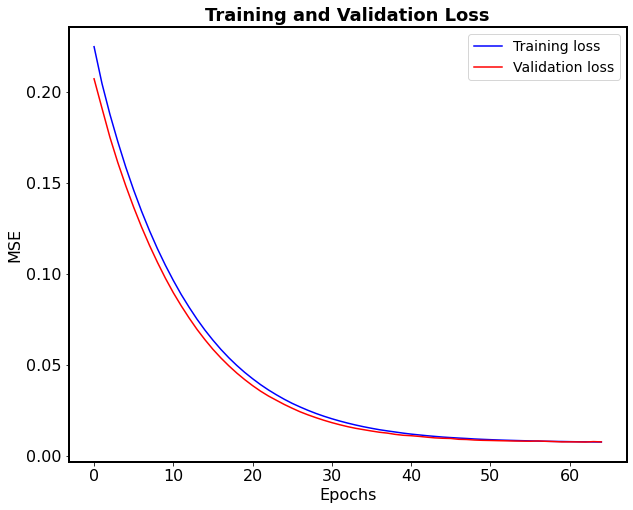

In [111]:
def visualize_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    figure_layout(figsize=(10,8),titel="Training and Validation Loss",xlabel="Epochs",ylabel="MSE",grid=False)
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.legend()
    plt.show()


visualize_loss(hist)